# 8.5 적대적 생성 신경망 소개

### 적대적 생성 신경망 (GAN)

- 적대적 생성 신경망(Generative Adversarial Networks, GAN)은 생성된 이미지가 실제 이미지와 통계적으로 거의 구분이 되지 않도록 강제하여 실제같은 이미지를 생성하는 모델


- VAE와 달리 잠재공간이 의미있는 구조를 보장하지 않음(연속적이지 않음)


### GAN을 구성하는 2가지 네트워크

1. 생성자 네트워크(generator network)
    - 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이미지로 디코딩(이미지 생성)
    
    
2. 판별자 네트워크(discriminator network)(또는 상대 네트워크)
    - 이미지를 입력으로 받아 실제 이미지인지 생성된(생성자 네트워크가 만든)이미지인지 판별
    

### GAN의 훈련

#### 2가지 네트워크의 훈련
1. 생성자 네트워크
    - 생성자 네트워크는 판별자 네트워크를 속이도록 훈련
    - 훈련이 계속되면서 점점 실제 이미지 같은 이미지를 생성
    

2. 판별자 네트워크
    - 생성된 이미지와 실제 이미지를 판별하도록 훈련(일반 이미지 분류 모델의 훈련과 같음)


#### GAN의 최적화

- GAN은 최적화 과정이 최솟값을 찾는 것이 아니라 두 힘간의 평형점을 찾는 다이나믹 시스템이므로 훈련하기 어려움

    - 일반적인 경사하강법
        - 고정된 손실에서 언덕을 내려오는 방법
    - GAN
        - 언덕을 내려오는 매 단계가 조금씩 전체 공간을 바꿈
        - 최적화의 최솟값이 고정된 시스템이 아님

    
<img src="./images/gan.png" alt="gan" align="left"/>

## 8.5.1 GAN 구현 방법

- 케라스를 통해 기본적인 형태의 GAN을 구현
    - 구체적으로는 심층 합성곱 GAN(Deep Convolutional GAN, DCGAN)을 구현
        - 생성자와 판별자가 심층 convnet
        

- CIFAR10 데이터셋 사용
    - 문제를 간단히 하기 위해 "frog" 클래스만 사용
    
    
### 구현할 GAN의 대략적인 구조

1. `generator` 네트워크는 `(latent_dim,)`크기의 벡터를 `(32, 32, 3)`크기의 이미지로 매핑(생성자 네트워크)


2. `discriminator` 네트워크는 `(32, 32, 3)`크기의 이미지가 진짜일 확률을 이진 값으로 매핑(판별자 네트워크)


3. `gan` 네트워크는 잠재공간의 벡터를 디코딩 한 것을 판별자의 평가로 매핑(생성자와 판별자를 연결하는 GAN 네트워크) 
    - `gan(x) = discriminator(generator(x))` 
    

4. 진짜 이미지, 가짜 이미지 샘플과 레이블(진짜, 가짜)을 사용해 판별자를 훈련
    -  이미지 분류 모델 훈련과 동일


5. 판별자를 속이도록 생성자를 훈련
    - GAN 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용
    - GAN 모델의 손실은 판별자의 출력이므로 판별자가 "진짜"로 분류하도록 만드는 방향으로 생성자의 가중치를 이동한다는 뜻

## 8.5.2 훈련 방법

- 이 기법들은 이론에 바탕을 둔 것이 아니라 경험(실험)을 통해 잘 작동한다고 알려진 몇가지 기법들임 (GAN은 훈련 및 튜닝이 상당히 어려움)


- 더 많은 방법들은 여러 GAN의 논문들에서 찾아볼 수 있음

### GAN의 생성자와 판별자를 구현하는데 사용할 몇가지 기법들

- 생성자의 마지막 활성화로 `sigmoid` 대신에 `tanh` 사용


- 균등 분포가 아닌 정규 분포(가우시안 분포)를 사용해 잠재공간의 포인트를 샘플링


- GAN 훈련은 동적 평형을 만들기 때문에 여러 방식으로 갇힐 수 있는데 모델에 무작위성을 주입하면 이를 방지하는데 도움이 됨
    - 판별자에 Dropout을 사용
    - 판별자의 label에 랜덤 노이즈 추가


- MaxPooling 연산과 ReLU는 gradient를 sparse하게 할 수 있는데 sparse gradient는 GAN의 훈련을 방해하므로 이를 다른 방법으로 대체
    - MaxPooling은 strides로 대체
    - ReLU 활성화는 LeakyReLU로 대체
        - LeakyReLU는 음수의 활성화 값을 조금 허용
    
    
- convolution과 deconvolution 연산 시 픽셀 공간을 균일하게 다루지 못해 체스판 모양이 종종 나타나는 경우가 있음
    - stride 크기로 나누어 질 수 있는 커널 크기를 사용해 픽셀 공간을 균일하게 다루도록 함

## 8.5.3 생성자 구현

In [1]:
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, LeakyReLU, Reshape, Conv2DTranspose

latent_dim = 32

height = 32
width =32
channels = 3

generator_input = Input(shape=(latent_dim,))

# 활성화로 LeakyReLU를 사용
# kernel 크기가 stride 크기로 나눠지도록 함
x = Dense(128 * 16 * 16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16, 16, 128))(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

# strides를 사용해 16x16크기를 32x32로 업샘플링
x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)

# 마지막 층의 활성화로 tanh 사용
x = Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = Model(generator_input, x)

generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

## 8.5.4 판별자 구현

In [2]:
from tensorflow.keras.layers import Flatten, Dropout

discriminator_input = Input(shape=(height, width, channels))

# 활성화로 LeakyReLU를 사용
# kernel 크기가 stride 크기로 나눠지도록 함
x = Conv2D(128, 3)(discriminator_input)
x = LeakyReLU()(x)

x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)

x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)

x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)

x = Flatten()(x)

# 판별자 네크워크에 Dropout 사용
x = Dropout(0.5)(x)

# 이진 분류
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

In [3]:
from tensorflow.keras.optimizers import RMSprop

# gradient clipping 적용
# learning rate 감쇠 적용
discriminator_optimizer = RMSprop(lr=0.0005,
                                  clipvalue=1.0,
                                  decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

## 8.5.5 적대적 네트워크 구현

- gan의 학습(generator의 학습) 시 discriminator는 학습되지 않도록 하는 것이 중요

In [4]:
# gan의 훈련 시(gan.fit())에는 discriminator의 가중치가 훈련되지 않지만
# discriminator만 훈련 시(discriminator.fit())에는 가중치가 훈련되도록 설정
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

# gradient clipping 적용
# learning rate 감쇠 적용
gan_optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer,
            loss='binary_crossentropy')

## 8.5.6 DCGAN 훈련 방법

### 전체 훈련 반복 내용

#### 1. `discriminator`의 훈련
- 잠재 공간에서 무작위로 포인트 샘플링(랜덤 노이즈)
- 랜덤 노이즈를 사용해 `generator`에서 이미지 생성
- 생성된 이미지와 가짜 이미지를 섞고 이를 분류하도록 `discriminator`를 훈련
    - 여기서 target은 "진짜" 또는 "가짜"
    - 판별자가 "진짜"와 "가짜"를 잘 구분하도록 훈련한다는 의미
        
        
#### 2. `gan(generator)`의 훈련
- 잠재 공간에서 무작위로 포인트 샘플링(랜덤 노이즈)
- 랜덤 노이즈를 사용해 `gan(generator)`을 훈련
    - 여기서 target은 모두 "진짜"
    - 생성자가 판별자를 속이도록 훈련한다는 의미

In [5]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# CUDNN_STATUS_INTERNAL_ERROR 때문에 추가한 코드
# --------------------------------------------------
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
# --------------------------------------------------

(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# "frog" 클래스(6)만 선택
x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape((x_train.shape[0],) + 
                          (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20

# 이미지 저장 디렉토리
img_save_dir = "./datasets/gan_images"
if not os.path.exists(img_save_dir):
    os.mkdir(img_save_dir)
    
# # 가중치 저장 디렉토리
# weight_save_dir = "./datasets/gan_weights"
# if not os.path.exists(weight_save_dir):
#     os.mkdir(weight_save_dir)
    
start = 0

for step in range(iterations + 1):
    # 1. 판별자 훈련 부분
    
    # 정규 분포(가우시안 분포)를 사용해 잠재공간의 포인트를 샘플링
    random_latent_vectors = np.random.normal(size=(batch_size,
                                                   latent_dim))
    # 가짜 이미지 생성
    generated_images = generator.predict(random_latent_vectors)
    
    # 진짜 이미지 생성
    stop = start + batch_size
    real_images = x_train[start:stop]
    
    # 전체 이미지 생성(가짜 이미지와 진짜 이미지를 연결)
    combinated_images = np.concatenate([generated_images, real_images])
    
    # 전체 레이블 생성 (가짜 이미지 레이블과 진짜 이미지 레이블을 연결)
    # 참고 : 가짜를 1, 진짜를 0
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    
    # 판별자의 label에 랜덤 노이즈 추가
    labels += 0.05 * np.random.random(labels.shape)
    
    # 판별자 훈련
    d_loss = discriminator.train_on_batch(combinated_images, labels)
    
    
    # 2. gan(생성자) 훈련 부분
    
     # 정규 분포(가우시안 분포)를 사용해 잠재공간의 포인트를 샘플링
    random_latent_vectors = np.random.normal(size=(batch_size,
                                                   latent_dim))
    
    # 모두 진짜로 된 레이블 생성
    misleading_targets = np.zeros((batch_size, 1))
    
    # gan(생성자) 훈련
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    # 1000번의 스텝마다 가중치, 이미지 저장 및 손실 출력
    if step % 1000 == 0:
#         gan.save_weights(os.path.join(weight_save_dir, 'gan.h5'))
        
        print('discriminator loss :', d_loss)
        print('generator(gan) loss :', a_loss)
        
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(img_save_dir,
                              'generated_frog_' + str(step) + '.png'))

discriminator loss : 0.6916938
generator(gan) loss : 0.69387305
discriminator loss : 0.6853689
generator(gan) loss : 0.74915
discriminator loss : 0.6960942
generator(gan) loss : 0.73681086
discriminator loss : 0.71090496
generator(gan) loss : 0.77386296
discriminator loss : 0.6984137
generator(gan) loss : 0.749069
discriminator loss : 0.6917417
generator(gan) loss : 0.75571203
discriminator loss : 0.6566273
generator(gan) loss : 0.7294509
discriminator loss : 0.6883997
generator(gan) loss : 2.0629532
discriminator loss : 0.6691274
generator(gan) loss : 0.87806195
discriminator loss : 0.66231525
generator(gan) loss : 0.85201234
discriminator loss : 0.78106225
generator(gan) loss : 0.9993564


### 학습과정 팁

#### gan의 손실은 크게 증가하고 판별자의 손실이 0으로 가는 경우
- 판별자의 학습률을 낮추고 판별자의 드롭아웃 비율을 높여서 시도

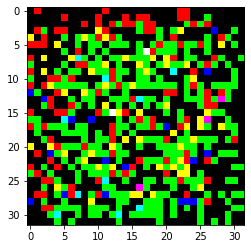

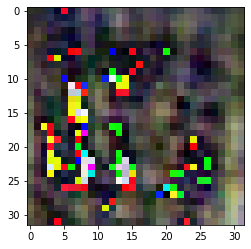

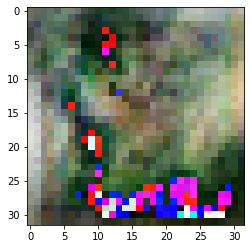

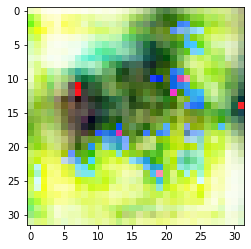

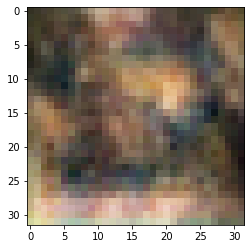

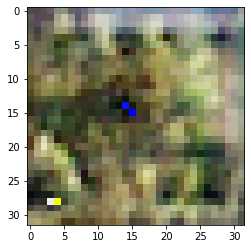

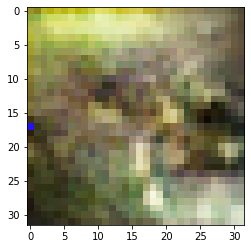

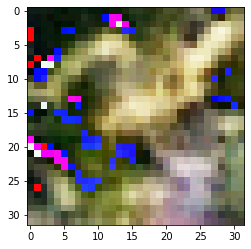

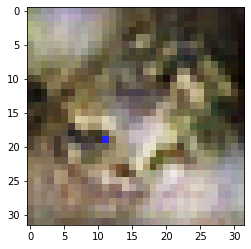

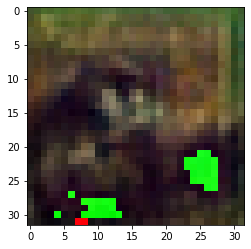

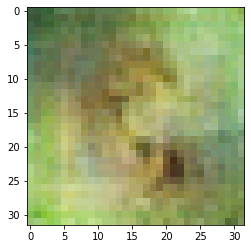

In [6]:
# 학습 과정 이미지 출력

import cv2
import matplotlib.pyplot as plt

for step in range(11):
    img_path = os.path.join(img_save_dir,
                            'generated_frog_' + str(step*1000) + '.png')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img).astype('float32') / 255.

    plt.figure()
    plt.imshow(img)

plt.show()

### 결과 분석

- 학습이 되면서 랜덤 노이즈를 "frog"의 형태의 이미지에 가깝게 만들어내는 것을 볼 수 있음

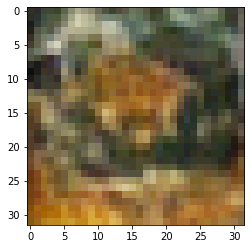

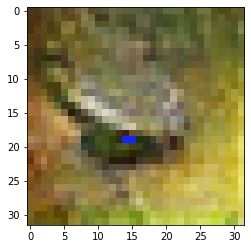

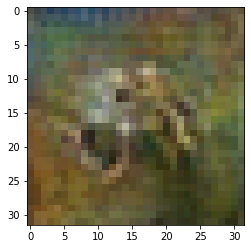

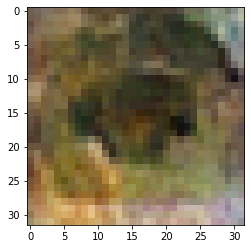

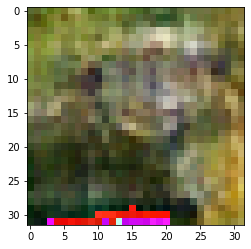

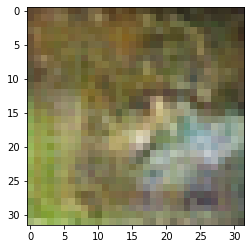

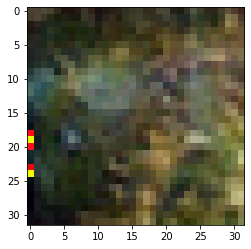

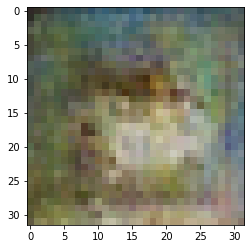

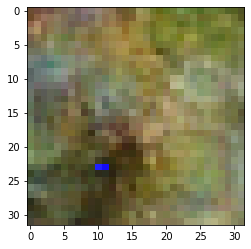

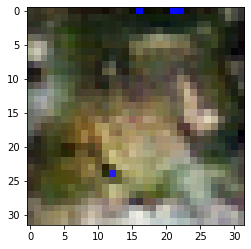

In [11]:
# 최종 gan 모델로 10개의 이미지 생성

for i in range(10):
    random_latent_vectors = np.random.normal(size=(10, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    img = image.array_to_img(generated_images[0] * 255., scale=False)
    
#     img_path = os.path.join(img_save_dir,
#                             'generated_frog_' + str(step*1000) + '.png')
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = np.array(img).astype('float32') / 255.

    plt.figure()
    plt.imshow(img)

plt.show()

### 결과 분석

- 학습한 모델이 "frog" 클래스의 이미지와 유사한 이미지를 생성해냄
- 하지만 어느정도 노이즈가 섞인 이미지도 있음

## 8.5.7 정리

- GAN은 생성자 네트워크와 판별자 네트워크가 연결되어 구성
    - 판별자는 생성자의 출력인 가짜 이미지와 진짜 이미지를 구분하도록 훈련됨
    - 생성자는 판별자를 속이도록 훈련됨
    - 생성자는 실제 이미지를 보지 않으며 오직 판별자의 판별 결과를 통해서만 정보를 얻음
    

- GAN은 훈련이 어려움
    - 경사하강법이 아닌 동적 과정
    - 경험적으로 찾은 여러 기법들을 사용하고 많은 튜닝이 필요
    

- GAN은 매우 실제같은 이미지를 만들 수 있음
    - VAE와 달리 잠재 공간이 연속적이고 구조적이지 않음
    - 따라서 개념 벡터를 사용한 이미지 변형의 애플리케이션에는 맞지 않음